<a href="https://colab.research.google.com/github/jvthecreator/Jupiter-RocketPy-Simulations/blob/main/Ballistic_Scenario_dispersion_without_Airbrake_MR_LASC_Odisseia_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started


Here we go through a complete rocket trajectory simulation to get you started.

Also, a more in detail complete description of the simulation can also be found in the [First Simulation Section of the RocketPy Documentation](https://docs.rocketpy.org/en/latest/user/first_simulation.html).

If you want, you can open this notebook in Google Colab by clicking the badge below.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RocketPy-Team/rocketpy/blob/master/docs/notebooks/getting_started_colab.ipynb)

Let's start by importing the rocketpy module.


### Odisseia II

In [ ]:
!pip install rocketpy
from rocketpy import *

from google.colab import drive
drive.mount('/gdrive')

import os
os.chdir('/gdrive/MyDrive/Projeto Jupiter')

os.listdir()
!sed -i -e '

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.5/372.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.3 MB/s eta 0:00:00
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65860 sha256=d62a71b3f24d2ca7bc332017c906b779823022453abc9c7edabdfa9eec4369c6
  Stored in directory: /root/.cache/pip/wheels/83/ee/f2/65cecfd948f1429ead035fd6d56bc6bd6574a636ddc4d65cbd
Successfully built simplekml
Mounted at /gdrive
/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


### Setting Up a Simulation


### Creating an Environment for LASC

The `Environment` class is used to define the atmosphere, the winds, and the gravity models.

You can find more information about the `Environment` class in the [Environment Class Usage Docs](https://docs.rocketpy.org/en/latest/notebooks/environment/environment_class_usage.html).


In [ ]:
env = Environment(latitude=-21.90795, longitude=-48.96156, elevation=495)


To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.


In [ ]:
import datetime
import inspect
import traceback
import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp


tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
    (2025, 11, 5, 12)
)  # Hour given in UTC time

In [ ]:
env.set_atmospheric_model(type="custom_atmosphere",
    pressure=None, #Surface Pressure: 853.76 hPa
    temperature=300,
    wind_u=[(0,2.78), (5000,2.78)],
    wind_v=[(0,0), (5000,0)],
)


Then, we tell env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.


We can see what the weather will look like by calling the info method!



Gravity Details

Acceleration of gravity at surface level:    9.7860 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5452 m/s²


Launch Site Details

Launch Date: 2025-11-05 12:00:00 UTC
Launch Site Latitude: -21.90795°
Launch Site Longitude: -48.96156°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 90584.06 W    7572074.74 S
Launch Site UTM zone: 23K
Launch Site Surface Elevation: 495.0 m


Atmospheric Model Details

Atmospheric Model Type: custom_atmosphere
custom_atmosphere Maximum Height: 80.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 2.78 m/s
Surface Wind Direction: 270.00°
Surface Wind Heading: 90.00°
Surface Pressure: 955.47 hPa
Surface Temperature: 300.00 K
Surface Air Density: 1.110 kg/m³
Surface Speed of Sound: 347.22 m/s


Earth Model Details

Earth Radius at Launch site: 6375.18 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034



Gravity Model Plots


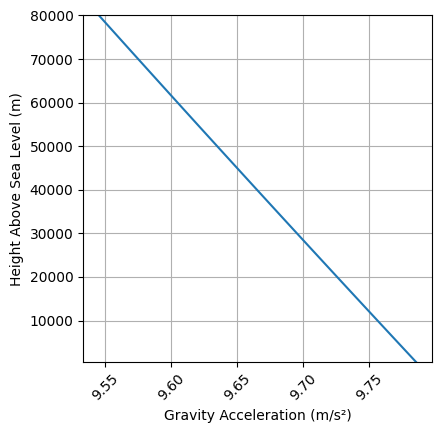



Atmospheric Model Plots


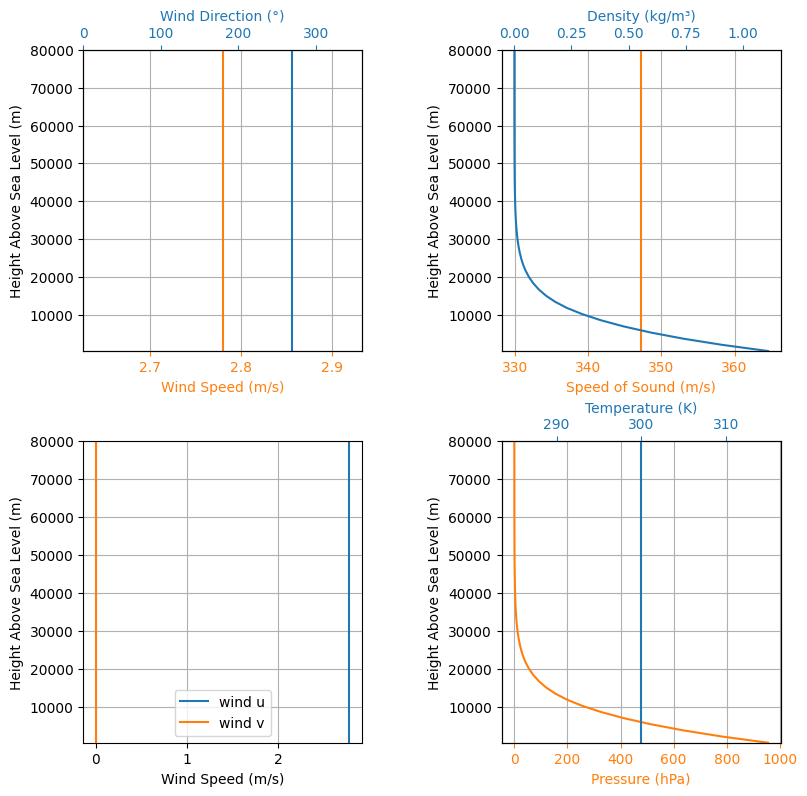

In [ ]:
env.all_info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

See [Solid Motor Class Usage Docs](https://docs.rocketpy.org/en/latest/user/motors/solidmotor.html) for more information.


In [ ]:
Mandioca = SolidMotor(
    thrust_source='./Aerodinamica/RocketPy.aero/Simulacoes/Pacifico/Data/Pacifico/mandioca_2024.csv',
    dry_mass=0,
    dry_inertia=(0, 0, 0),
    nozzle_radius=65/2000,
    grain_number=5,
    grain_density=1730.54,
    grain_outer_radius=94/2000,
    grain_initial_inner_radius=31.75/2000,
    grain_initial_height=15.135/100,
    grain_separation=9/1000,
    grains_center_of_mass_position=0.532,
    center_of_dry_mass_position=0,
    nozzle_position=0,
    burn_time=4.301,
    throat_radius=11/1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

**Pay special attention to _position_ related parameters:**
More details on [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)


To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the all_info method if you want more information all at once!


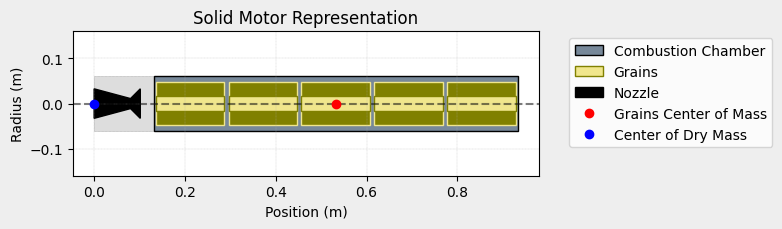

In [ ]:
Mandioca.draw()

Nozzle Details
Nozzle Radius: 0.0325 m
Nozzle Throat Radius: 0.011 m

Grain Details
Number of Grains: 5
Grain Spacing: 0.009 m
Grain Density: 1730.54 kg/m3
Grain Outer Radius: 0.047 m
Grain Inner Radius: 0.015875 m
Grain Height: 0.15134999999999998 m
Grain Volume: 0.001 m3
Grain Mass: 1.610 kg

Motor Details
Total Burning Time: 4.301 s
Total Propellant Mass: 8.051 kg
Structural Mass Ratio: 0.000
Average Propellant Exhaust Velocity: 1330.196 m/s
Average Thrust: 2490.104 N
Maximum Thrust: 4882.47264443292 N at 1.9550000000000018 s after ignition.
Total Impulse: 10709.936 Ns



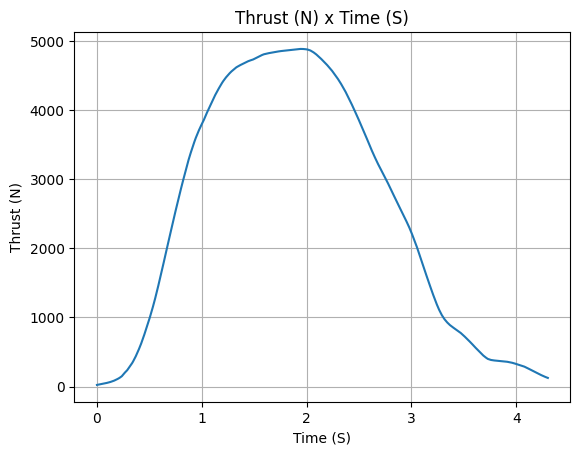

In [ ]:
Mandioca.info()

### Creating a Rocket


A rocket is composed of several components. Namely, we must have a motor, a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes.

You can find more information about the `Rocket` class in the [Rocket Class Usage Docs](https://docs.rocketpy.org/en/latest/user/rocket.html).

Let's start by initializing our rocket, named Odisseia II, entering inertia properties, some dimensions and drag curves.

**Pay special attention to _position_ related parameters:**
More details on [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)


In [ ]:
Cd_RASAero = "./Aerodinamica/RocketPy.aero/Simulacoes/LASC 2025/CD_Superatualizado.csv"
OdisseiaII = Rocket(
    radius= 0.0817,
    mass=25.414,
    inertia=(14.428, 14.428, 0.128),
    power_off_drag= Cd_RASAero,
    power_on_drag= Cd_RASAero,
    center_of_mass_without_motor=1.712433,
    coordinate_system_orientation='nose_to_tail',
    )


rail_buttons = OdisseiaII.set_rail_buttons(
    upper_button_position=1.838,
    lower_button_position=2.792,
    angular_position=45,
)

In [ ]:
OdisseiaII.add_motor(Mandioca, position=2.856)

#### Adding Aerodynamic Surfaces


Now we define the aerodynamic surfaces. They are really straight forward with special attention needed only for the position values. Here is a quick guide:

- The positions given **must** be relative to the same coordinate system as the rockets;
- Position of the Nosecone refers to the tip of the nose;
- Position of fins refers to the point belonging to the root chord which is highest in the rocket coordinate system;
- Position of the tail the point belonging to the tail which is highest in the rocket coordinate system.

See more details in [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)


In [ ]:
naca0012 = './Aerodinamica/RocketPy.aero/Simulacoes/Data/NACA0012-radians.csv'

nose_cone = OdisseiaII.add_nose(
      length=0.587, kind="vonKarman", position=0
    )

fin_set = OdisseiaII.add_trapezoidal_fins(
    n=4,
    root_chord=0.175,
    tip_chord=0.145,
    span=0.17,
    position=2.587,
    cant_angle=0.5,
    airfoil=(naca0012, "degrees"),
    sweep_length=0.03,
)

tail = OdisseiaII.add_tail(
    top_radius=0.0817, bottom_radius=0.0655, length=0.052, position=2.821
)

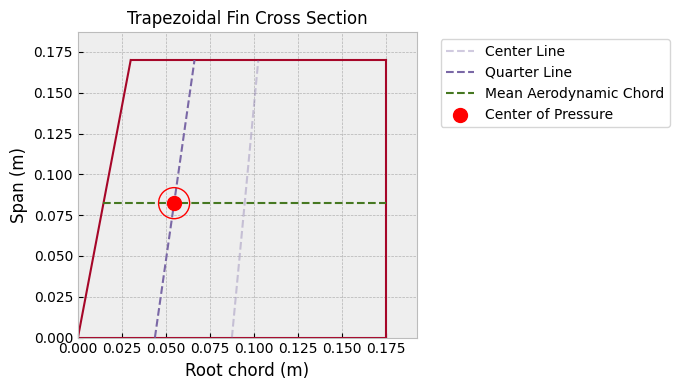

In [ ]:
fin_set.draw()

To see all information regarding the rocket we just defined we run:



Inertia Details

Rocket Mass: 25.414 kg (without motor)
Rocket Dry Mass: 25.414 kg (with unloaded motor)
Rocket Loaded Mass: 33.465 kg
Rocket Structural Mass Ratio: 0.759
Rocket Inertia (with unloaded motor) 11: 14.428 kg*m2
Rocket Inertia (with unloaded motor) 22: 14.428 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.128 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0817 m
Rocket Frontal Area: 0.020970 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.000 m
Rocket Center of Dry Mass - Nozzle Exit: 1.144 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.612 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.147 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 11.469/rad
Tail Lift Coefficient

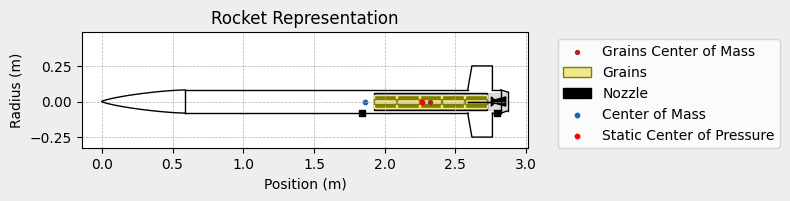


Mass Plots
----------------------------------------


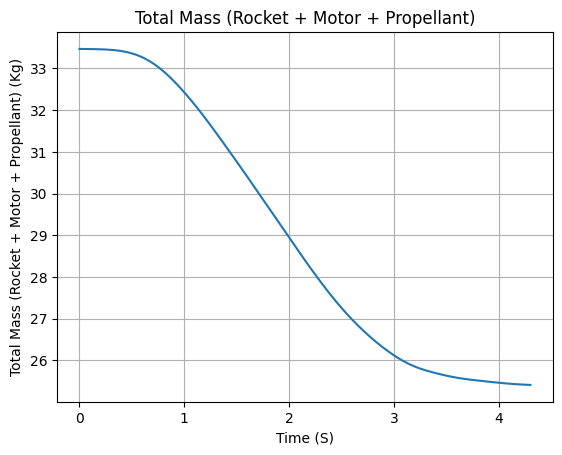

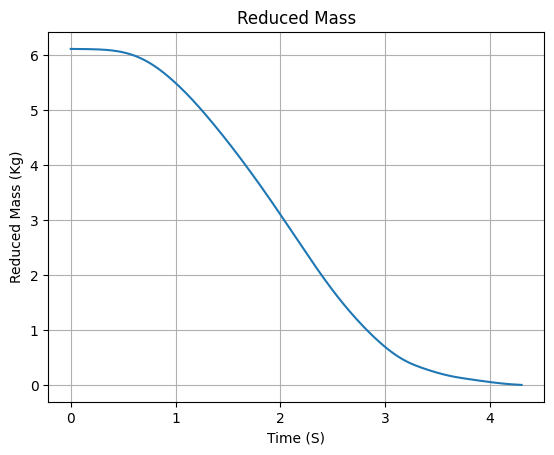


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


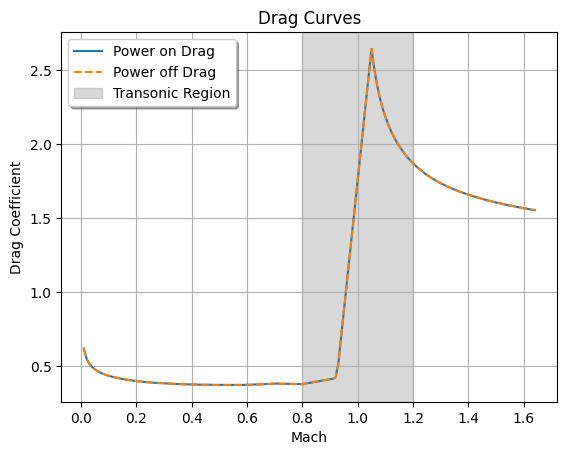


Stability Plots
--------------------


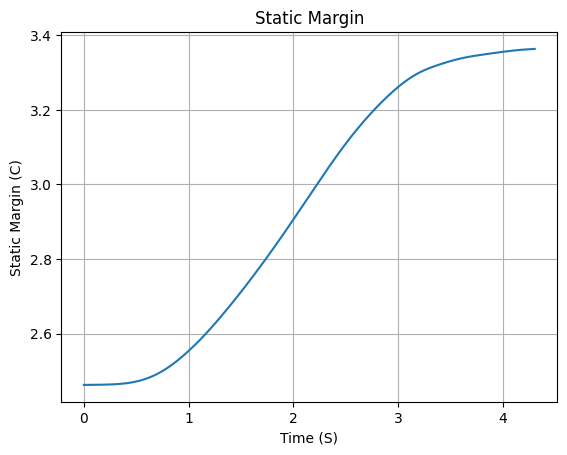

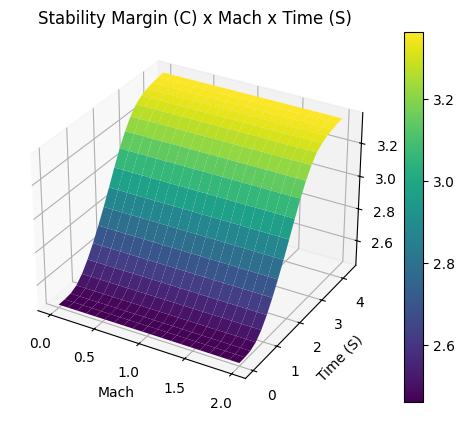


Thrust-to-Weight Plot
----------------------------------------


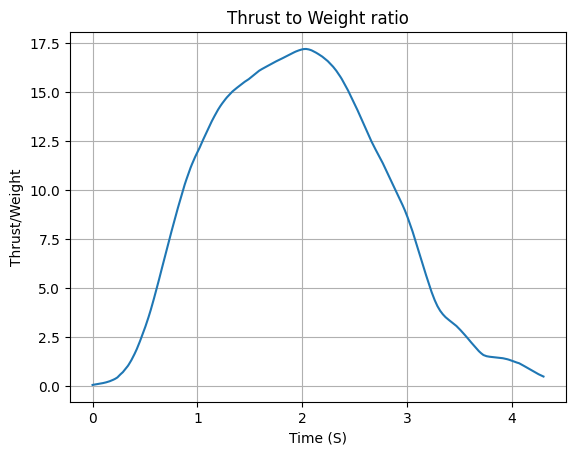

In [ ]:
OdisseiaII.all_info()

#### Adding Parachutes


Finally, we have parachutes! Odisseia II will have two parachutes, Drogue and Main.

For more details see [Adding Parachutes](https://docs.rocketpy.org/en/latest/user/rocket.html#adding-parachutes)


In [ ]:
'''Main = OdisseiaII.add_parachute(
    "Main",
    cd_s=9.17,
    trigger=427, #426
    sampling_rate=50,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)'''

'''Drogue = OdisseiaII.add_parachute(
    "Drogue",
    cd_s=1.08,
    trigger="apogee",
    sampling_rate=50,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)'''

'Drogue = OdisseiaII.add_parachute(\n    "Drogue",\n    cd_s=1.08,\n    trigger="apogee",\n    sampling_rate=50,\n    lag=1.5,\n    noise=(0, 8.3, 0.5),\n)'

## Simulating a Flight

Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.


In [ ]:
test_flight = Flight(
    rocket=OdisseiaII, environment=env, rail_length=6, inclination=80, heading=0
)

## Analyzing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.



Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 495.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: -0.920 | e1: 0.081 | e2: 0.033 | e3: 0.381
Euler Angles - Spin φ : 315.00° | Nutation θ: -10.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.463 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: -2.78 m/s


Launch Rail

Launch Rail Length: 6 m
Launch Rail Inclination: 80.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.930 s
Rail Departure Velocity: 27.222 m/s
Rail Departure Stability Margin: 2.537 c
Rail Departure Angle of Attack: 5.831°
Rail Departure Thrust-Weight Ratio: 11.077
Rail Departure Reynolds Number: 2.686e+05


Burn out State

Burn out time: 4.301 s
Altitude at burn out: 1219.448 m (ASL) | 724.448 m (AGL)
Rocket speed at burn out: 295.754 m/s
Freestream veloc

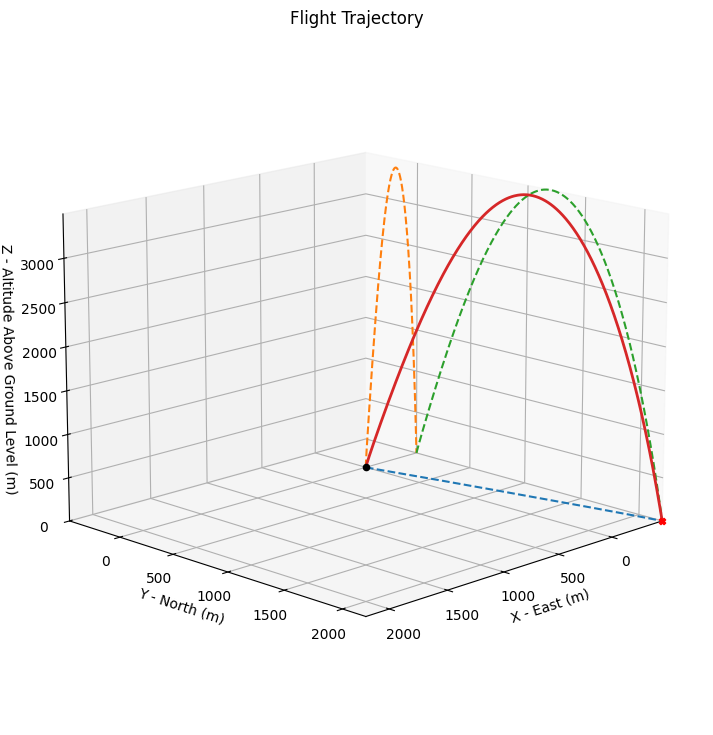



Trajectory Kinematic Plots



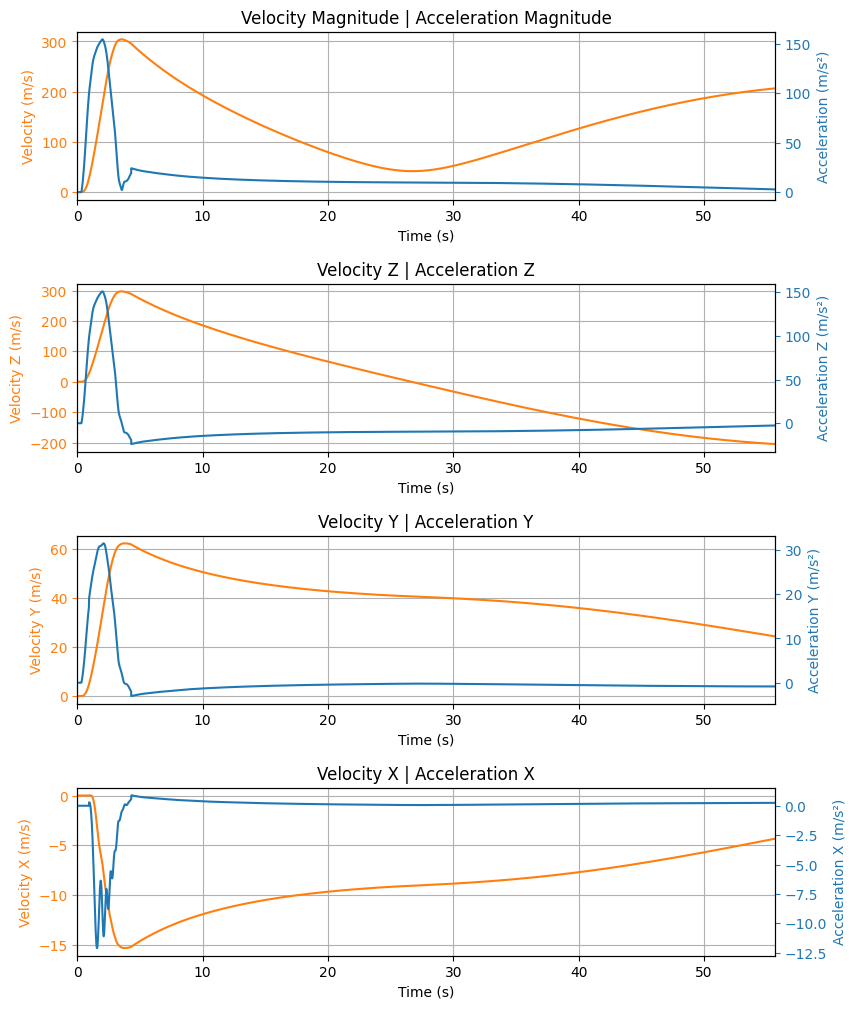



Angular Position Plots



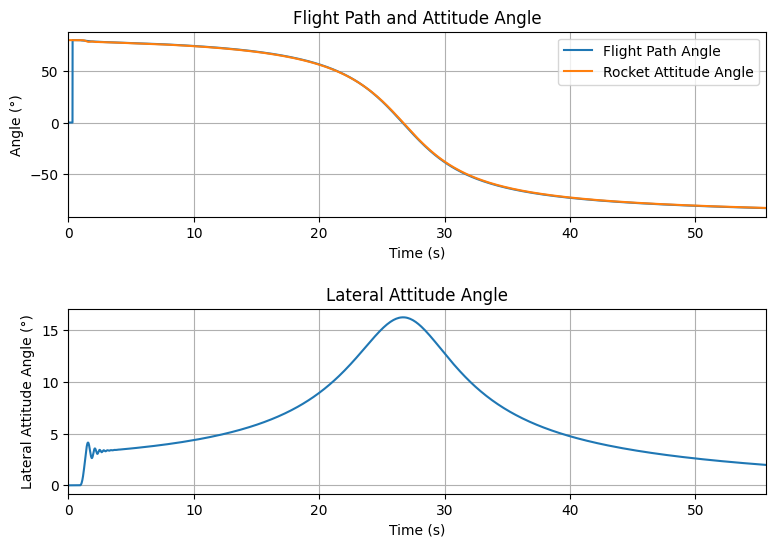



Path, Attitude and Lateral Attitude Angle plots



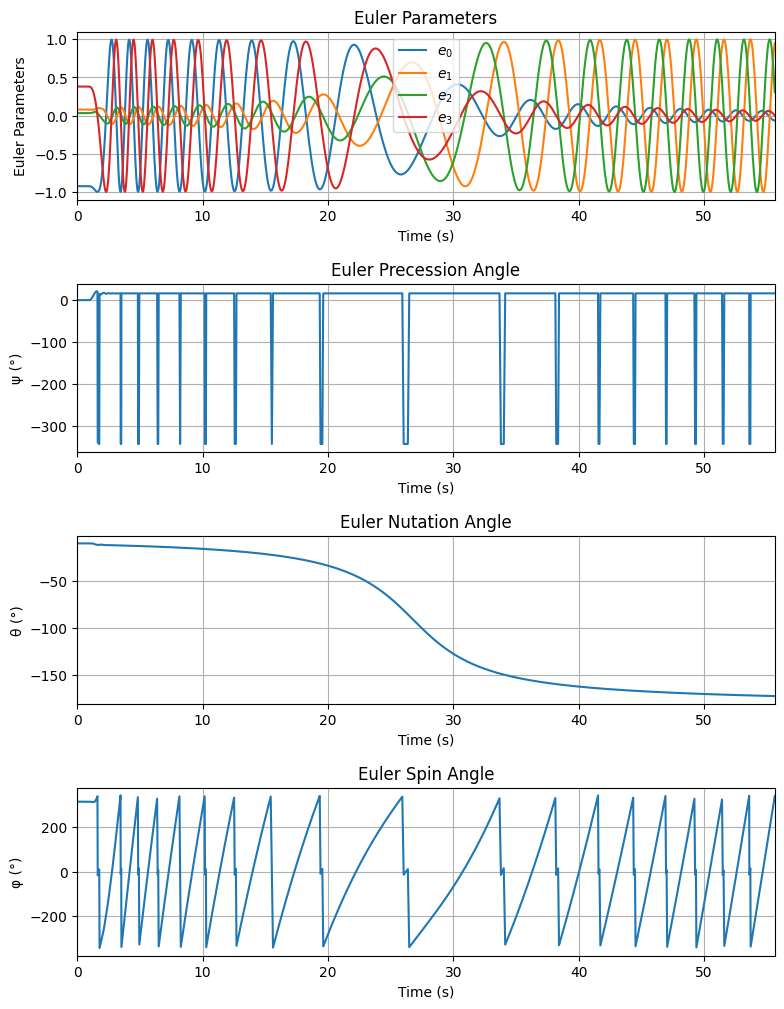



Trajectory Angular Velocity and Acceleration Plots



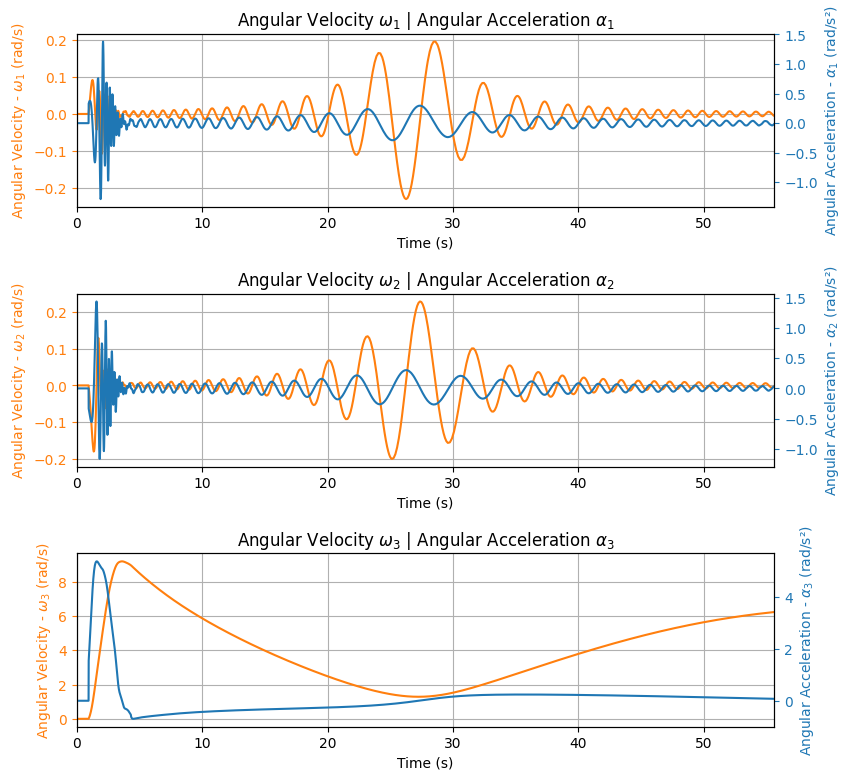



Aerodynamic Forces Plots



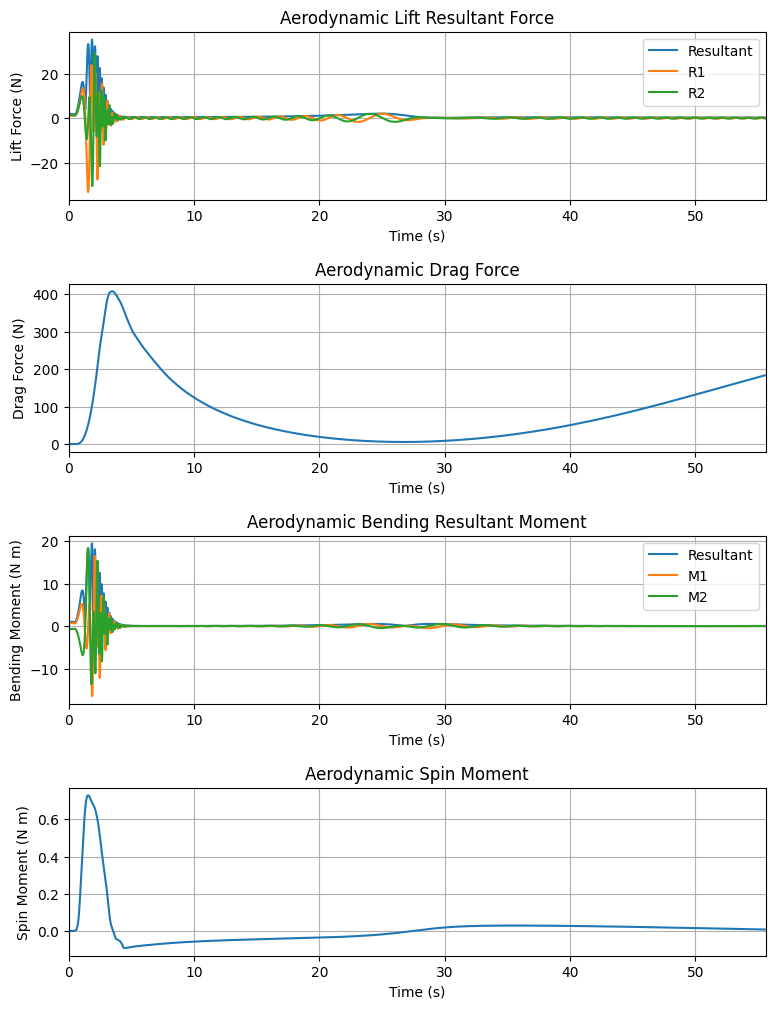



Rail Buttons Forces Plots



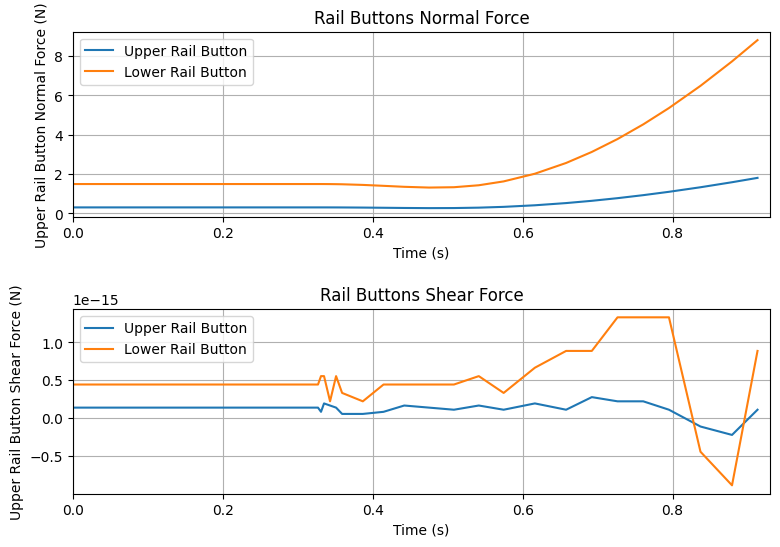



Trajectory Energy Plots



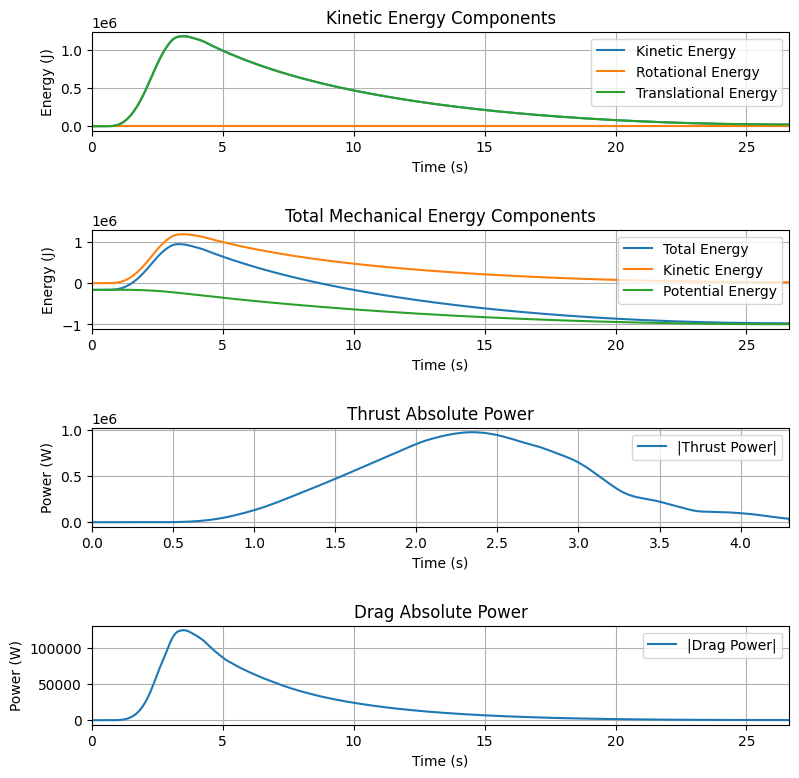



Trajectory Fluid Mechanics Plots



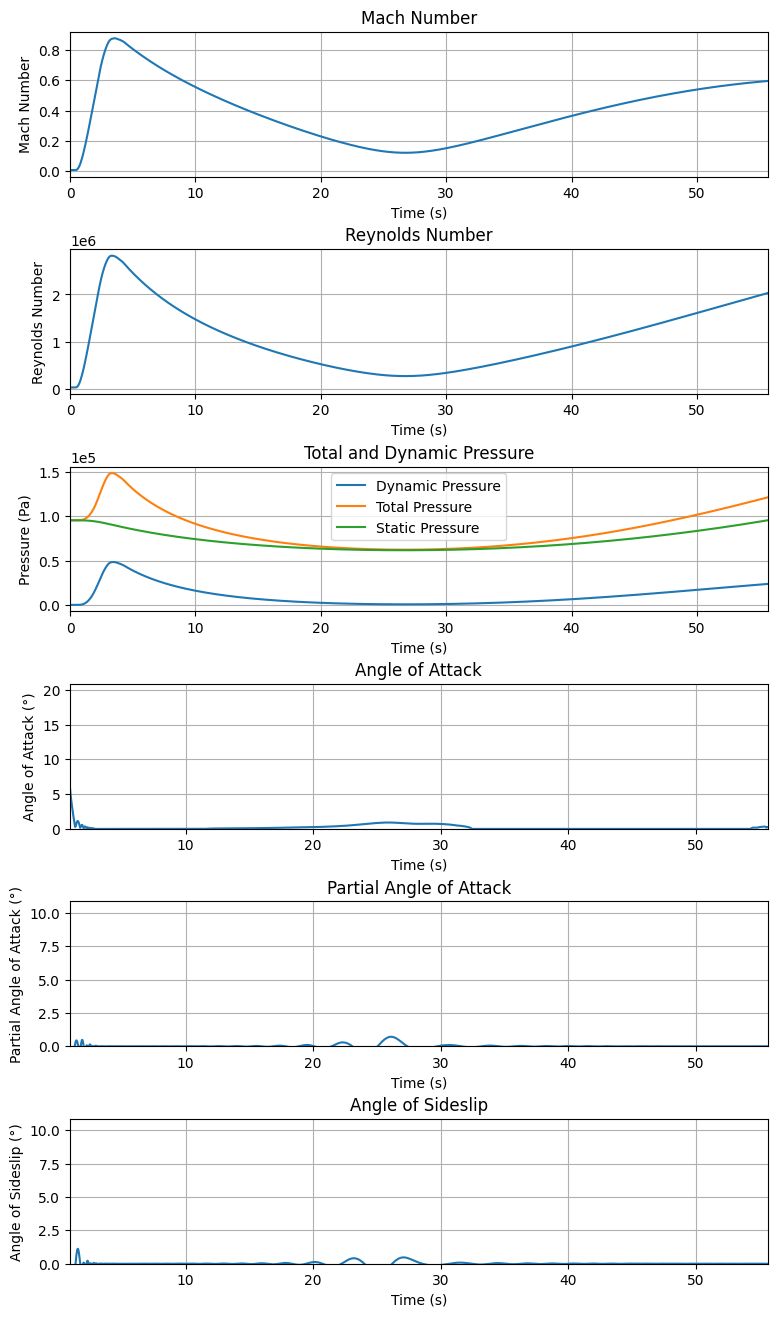



Trajectory Stability and Control Plots



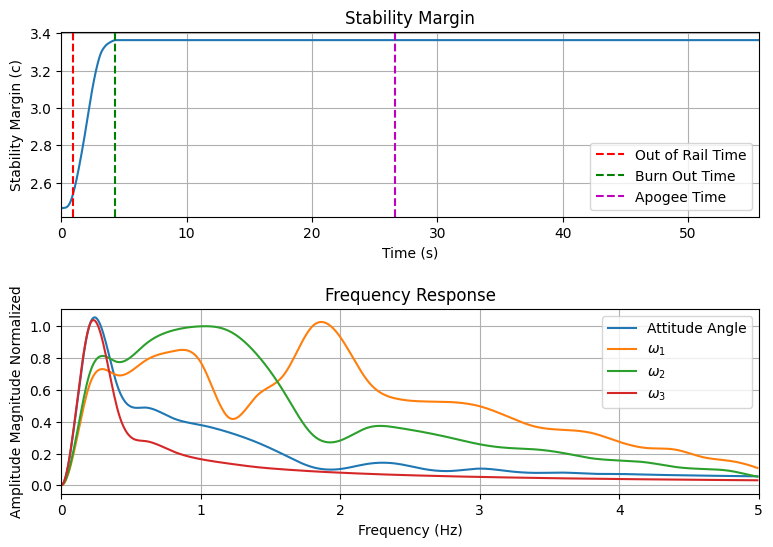



Rocket and Parachute Pressure Plots



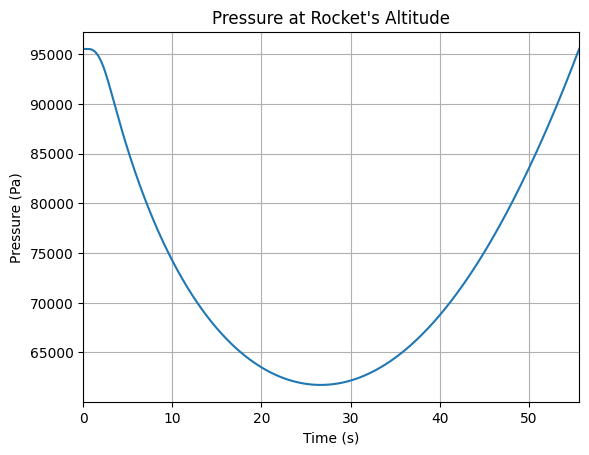


Rocket has no parachutes. No parachute plots available


In [ ]:
test_flight.all_info()

Export Flight Trajectory to a .kml file so it can be opened on Google Earth


In [ ]:
test_flight.export_kml(
    file_name="trajectory.kml",
    extrude=True,
    altitude_mode="relative_to_ground",
)

File  trajectory.kml  saved with success!


In [ ]:
def fin_flutter_analysis(
    fin_thickness, shear_modulus, flight, see_prints=True, see_graphs=True
):
    """Calculate and plot the Fin Flutter velocity using the pressure profile
    provided by the selected atmospheric model. It considers the Flutter
    Boundary Equation that published in NACA Technical Paper 4197.
    These results are only estimates of a real problem and may not be useful for
    fins made from non-isotropic materials.
    Currently, this function works if only a single set of fins is added,
    otherwise it will use the last set of fins added to the rocket.

    Parameters
    ----------
    fin_thickness : float
        The fin thickness, in meters
    shear_modulus : float
        Shear Modulus of fins' material, must be given in Pascal
    flight : Flight
        Flight object containing the rocket's flight data
    see_prints : boolean, optional
        True if you want to see the prints, False otherwise.
    see_graphs : boolean, optional
        True if you want to see the graphs, False otherwise. If False, the
        function will return the vectors containing the data for the graphs.

    Return
    ------
    None
    """
    found_fin = False

    # First, we need identify if there is at least one fin set in the rocket
    for aero_surface in flight.rocket.fins:
        if isinstance(aero_surface, TrapezoidalFins):
            # s: surface area; ar: aspect ratio; la: lambda
            root_chord = aero_surface.root_chord
            s = (aero_surface.tip_chord + root_chord) * aero_surface.span / 2
            ar = aero_surface.span * aero_surface.span / s
            la = aero_surface.tip_chord / root_chord
            if not found_fin:
                found_fin = True
            else:
                warnings.warn("More than one fin set found. The last one will be used.")
    if not found_fin:
        raise AttributeError(
            "There is no TrapezoidalFins in the rocket, can't run Flutter Analysis."
        )

    # Calculate variables
    flutter_mach = _flutter_mach_number(
        fin_thickness, shear_modulus, flight, root_chord, ar, la
    )
    safety_factor = _flutter_safety_factor(flight, flutter_mach)

    # Prints and plots
    if see_prints:
        _flutter_prints(
            fin_thickness, shear_modulus, s, ar, la, flutter_mach, safety_factor, flight
        )
    if see_graphs:
        _flutter_plots(flight, flutter_mach, safety_factor)
    else:
        return flutter_mach, safety_factor


def _flutter_mach_number(fin_thickness, shear_modulus, flight, root_chord, ar, la):
    flutter_mach = (
        (shear_modulus * 2 * (ar + 2) * (fin_thickness / root_chord) ** 3)
        / (1.337 * (ar**3) * (la + 1) * flight.pressure)
    ) ** 0.5
    flutter_mach.set_title("Fin Flutter Mach Number")
    flutter_mach.set_outputs("Mach")
    return flutter_mach


def _flutter_safety_factor(flight, flutter_mach):
    """Calculates the safety factor for the fin flutter analysis.

    Parameters
    ----------
    flight : rocketpy.Flight
        Flight object containing the rocket's flight data
    flutter_mach : rocketpy.Function
        Mach Number at which the fin flutter occurs. See the
        `fin_flutter_analysis` function for more details.

    Returns
    -------
    rocketpy.Function
        The safety factor for the fin flutter analysis.
    """
    safety_factor = flutter_mach / flight.mach_number
    safety_factor.set_title("Fin Flutter Safety Factor")
    safety_factor.set_outputs("Safety Factor")
    return safety_factor


def _flutter_plots(flight, flutter_mach, safety_factor):
    """Plot the Fin Flutter Mach Number and the Safety Factor for the flutter.

    Parameters
    ----------
    flight : rocketpy.Flight
        Flight object containing the rocket's flight data
    flutter_mach : rocketpy.Function
        Function containing the Fin Flutter Mach Number,
        see fin_flutter_analysis for more details.
    safety_factor : rocketpy.Function
        Function containing the Safety Factor for the fin flutter.
        See fin_flutter_analysis for more details.

    Returns
    -------
    None
    """
    # TODO: move to rocketpy.plots submodule
    _ = plt.figure(figsize=(6, 6))
    ax1 = plt.subplot(211)
    ax1.plot(
        flutter_mach[:, 0],
        flutter_mach[:, 1],
        label="Fin flutter Mach Number",
    )
    ax1.plot(
        flight.mach_number[:, 0],
        flight.mach_number[:, 1],
        label="Rocket Freestream Speed",
    )
    ax1.set_xlim(0, flight.apogee_time if flight.apogee_time != 0.0 else flight.tFinal)
    ax1.set_title("Fin Flutter Mach Number x Time(s)")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Mach")
    ax1.legend()
    ax1.grid()

    ax2 = plt.subplot(212)
    ax2.plot(safety_factor[:, 0], safety_factor[:, 1])
    ax2.set_xlim(flight.out_of_rail_time, flight.apogee_time)
    ax2.set_ylim(0, 6)
    ax2.set_title("Fin Flutter Safety Factor")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Safety Factor")
    ax2.grid()

    plt.subplots_adjust(hspace=0.5)
    plt.show()


def _flutter_prints(
    fin_thickness,
    shear_modulus,
    s,
    ar,
    la,
    flutter_mach,
    safety_factor,
    flight,
):
    """Prints out the fin flutter analysis results. See fin_flutter_analysis for
    more details.

    Parameters
    ----------
    fin_thickness : float
        The fin thickness, in meters
    shear_modulus : float
        Shear Modulus of fins' material, must be given in Pascal
    s : float
        Fin surface area, in squared meters
    ar : float
        Fin aspect ratio
    la : float
        Fin lambda, defined as the tip_chord / root_chord ratio
    flutter_mach : rocketpy.Function
        The Mach Number at which the fin flutter occurs, considering the
        variation of the speed of sound with altitude. See fin_flutter_analysis
        for more details.
    safety_factor : rocketpy.Function
        The Safety Factor for the fin flutter. Defined as the Fin Flutter Mach
        Number divided by the Freestream Mach Number.
    flight : rocketpy.Flight
        Flight object containing the rocket's flight data

    Returns
    -------
    None
    """
    # TODO: move to rocketpy.prints submodule
    time_index = np.argmin(flutter_mach[:, 1])
    time_min_mach = flutter_mach[time_index, 0]
    min_mach = flutter_mach[time_index, 1]
    min_vel = min_mach * flight.speed_of_sound(time_min_mach)

    time_index = np.argmin(safety_factor[:, 1])
    time_min_sf = safety_factor[time_index, 0]
    min_sf = safety_factor[time_index, 1]
    altitude_min_sf = flight.z(time_min_sf) - flight.env.elevation

    print("\nFin's parameters")
    print(f"Surface area (S): {s:.4f} m2")
    print(f"Aspect ratio (AR): {ar:.3f}")
    print(f"tip_chord/root_chord ratio = \u03BB = {la:.3f}")
    print(f"Fin Thickness: {fin_thickness:.5f} m")
    print(f"Shear Modulus (G): {shear_modulus:.3e} Pa")

    print("\nFin Flutter Analysis")
    print(f"Minimum Fin Flutter Velocity: {min_vel:.3f} m/s at {time_min_mach:.2f} s")
    print(f"Minimum Fin Flutter Mach Number: {min_mach:.3f} ")
    print(f"Minimum Safety Factor: {min_sf:.3f} at {time_min_sf:.2f} s")
    print(f"Altitude of minimum Safety Factor: {altitude_min_sf:.3f} m (AGL)\n")

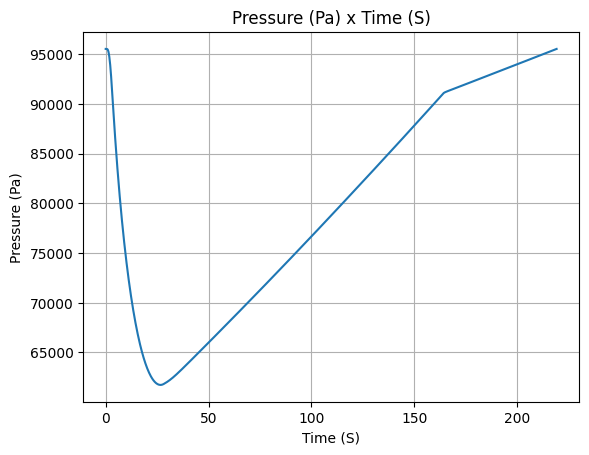

In [ ]:
test_flight.pressure()


Fin's parameters
Surface area (S): 0.0272 m2
Aspect ratio (AR): 1.063
tip_chord/root_chord ratio = λ = 0.829
Fin Thickness: 0.00500 m
Shear Modulus (G): 1.000e+10 Pa

Fin Flutter Analysis
Minimum Fin Flutter Velocity: 784.030 m/s at 219.22 s
Minimum Fin Flutter Mach Number: 2.258 
Minimum Safety Factor: 2.654 at 3.45 s
Altitude of minimum Safety Factor: 473.921 m (AGL)



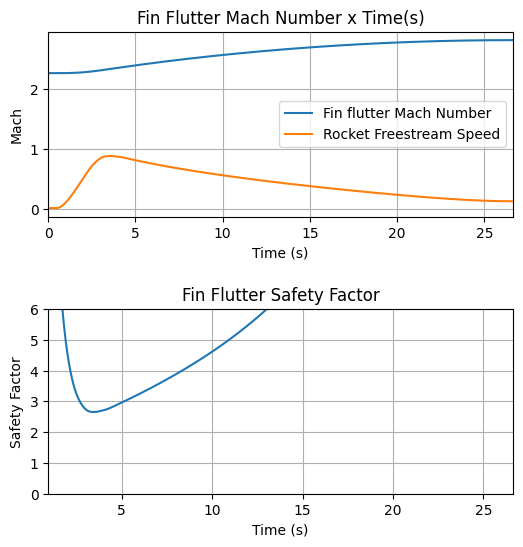

In [ ]:
fin_flutter_analysis((5)/1000, 10000000000, test_flight, see_prints=True, see_graphs=True)


Fin's parameters
Surface area (S): 0.0272 m2
Aspect ratio (AR): 1.063
tip_chord/root_chord ratio = λ = 0.829
Fin Thickness: 0.01800 m
Shear Modulus (G): 1.096e+10 Pa

Fin Flutter Analysis
Minimum Fin Flutter Velocity: 5607.182 m/s at 219.22 s
Minimum Fin Flutter Mach Number: 16.149 
Minimum Safety Factor: 18.980 at 3.45 s
Altitude of minimum Safety Factor: 473.921 m (AGL)



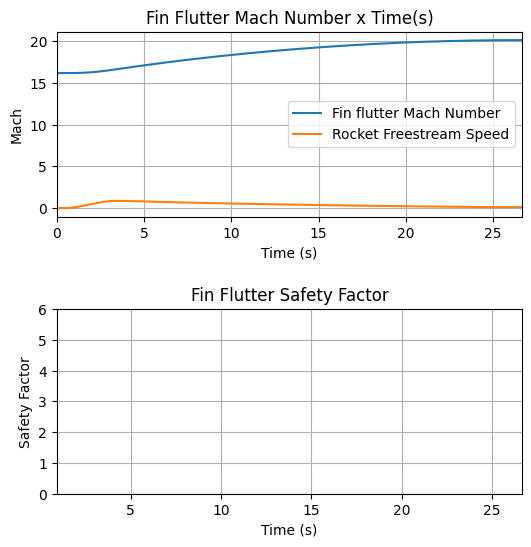

In [ ]:
fin_flutter_analysis((150*0.12)/1000, 10962664000, test_flight, see_prints=True, see_graphs=True)

## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy in cool ways to help us design our rocket.


### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.


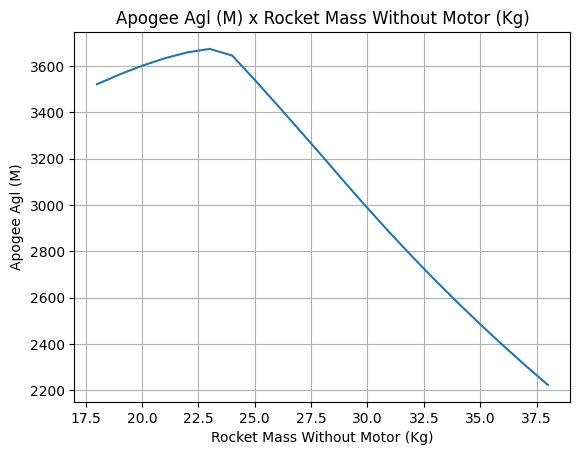

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Apogee AGL (m))'

In [ ]:
from rocketpy.utilities import apogee_by_mass

apogee_by_mass(flight=test_flight, min_mass=18, max_mass=38, points=21, plot=True)

### Out of Rail Speed as a Function of Mass

Lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.


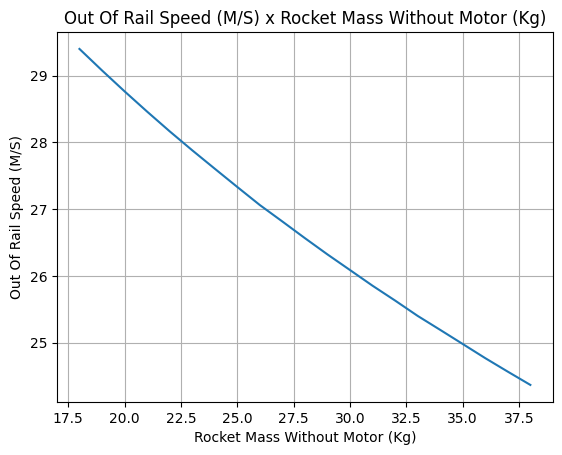

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Out of Rail Speed (m/s))'

In [ ]:
from rocketpy.utilities import liftoff_speed_by_mass

liftoff_speed_by_mass(flight=test_flight, min_mass=18, max_mass=38, points=21, plot=True)

##Simulating a Dispersion

In [ ]:
stochastic_env = StochasticEnvironment(
    environment=env
)

stochastic_env.visualize_attributes()

Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                495
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 -21.90795
	longitude                -48.96156
	timezone                 UTC

Stochastic Attributes:
	wind_velocity_x_factor   1.00000 ± 0.00000 (normal)
	wind_velocity_y_factor   1.00000 ± 0.00000 (normal)


In [ ]:
stochastic_mandioca = StochasticSolidMotor(
    solid_motor=Mandioca,
    burn_start_time=(0, 0, "normal"),
    grains_center_of_mass_position=0.001,
    grain_density=7.84,
    grain_separation=0.5 / 1000,
    grain_initial_height=5/1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(10709.812, 107.099),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)

In [ ]:
stochastic_mandioca.visualize_attributes()

Reporting the attributes of the `StochasticSolidMotor` object:

Constant Attributes:
	burn_out_time                    4.301
	center_of_dry_mass_position      0
	coordinate_system_orientation    nozzle_to_combustion_chamber
	dry_I_11                         0
	dry_I_12                         0
	dry_I_13                         0
	dry_I_22                         0
	dry_I_23                         0
	dry_I_33                         0
	dry_mass                         0
	grain_number                     5
	interpolate                      linear
	thrust_source                    ./Aerodinamica/RocketPy.aero/Simulacoes/Pacifico/Data/Pacifico/mandioca_2024.csv

Stochastic Attributes:
	burn_start_time                  0.00000 ± 0.00000 (normal)
	grain_density                    1730.54000 ± 7.84000 (normal)
	grain_initial_height             0.15135 ± 0.00500 (normal)
	grain_initial_inner_radius       0.01588 ± 0.00038 (normal)
	grain_outer_radius               0.04700 ± 0.00038 (normal)


In [ ]:
stochastic_OdisseiaII= StochasticRocket(
    rocket=OdisseiaII,
    radius=0.0005,
    mass=(25.414, 0.1, "normal"),
    inertia_11=0.0021,
    inertia_22=0.0021,
    inertia_33=0.0021,
    center_of_mass_without_motor=0.0005,
)

In [ ]:
stochastic_OdisseiaII.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   nose_to_tail
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	I_11_without_motor              14.42800 ± 0.00210 (normal)
	I_22_without_motor              14.42800 ± 0.00210 (normal)
	I_33_without_motor              0.12800 ± 0.00210 (normal)
	center_of_mass_without_motor    1.71243 ± 0.00050 (normal)
	mass                            25.41400 ± 0.10000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
	radius                          0.08170 ± 0.00050 (normal)


In [ ]:
stochastic_nose_cone = StochasticNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

stochastic_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins=fin_set,
    root_chord=0.0005,
    tip_chord=0.0005,
    span=0.0005,
)


stochastic_tail = StochasticTail(
    tail=tail,
    top_radius=0.0005,
    bottom_radius=0.0005,
    length=0.0005,
)

'''stochastic_rail_buttons = StochasticRailButtons(
    rail_buttons=rail_buttons(),angular_position=0.001, buttons_distance=0.0005
)'''

#stochastic_rail_buttons= StochasticRailButtons(
    #rail_buttons=rail_buttons, lower_button_position=(0.0005, "normal")
#)

'''stochastic_drogue = StochasticParachute(
    parachute=Drogue,
    cd_s=0.108,
    lag=0.3,
)'''

'''stochastic_main = StochasticParachute(
    parachute=Main,
    cd_s=0.917,
    lag=0.3,
)'''
# stochastic_airbrakes = StochasticAirBrakes(
#     air_brakes=air_brakes,
#     drag_coefficient_curve=1,
# )

'stochastic_main = StochasticParachute(\n    parachute=Main,\n    cd_s=0.917,\n    lag=0.3,\n)'

In [ ]:
stochastic_OdisseiaII.add_motor(stochastic_mandioca, position=(0.701+2.115,0.001))
stochastic_OdisseiaII.add_nose(stochastic_nose_cone, position=(0.01, 0.001))
stochastic_OdisseiaII.add_trapezoidal_fins(stochastic_fin_set, position=(2.115+0.701-0.27, 0.001))
stochastic_OdisseiaII.add_tail(stochastic_tail, position=(0.701+2.081,0.001))
#stochastic_OdisseiaII.set_rail_buttons(stochastic_rail_buttons, lower_button_position=(0.0005, "normal"))
#stochastic_OdisseiaII.add_parachute(stochastic_drogue)
#stochastic_OdisseiaII.add_parachute(stochastic_main)
#stochastic_Odisseia.add_air_brakes(air_brakes, controller_function)

In [ ]:
stochastic_OdisseiaII.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   nose_to_tail
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	I_11_without_motor              14.42800 ± 0.00210 (normal)
	I_22_without_motor              14.42800 ± 0.00210 (normal)
	I_33_without_motor              0.12800 ± 0.00210 (normal)
	center_of_mass_without_motor    1.71243 ± 0.00050 (normal)
	mass                            25.41400 ± 0.10000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
	radius                          0.08170 ± 0.00050 (normal)


In [ ]:
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=(80, 2),  # mean= 84.7, std=1
    heading=(0, 5),  # mean= 53, std=2
    terminate_on_apogee=False,
    time_overshoot=True,
)
stochastic_flight.visualize_attributes()

Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           6

Stochastic Attributes:
	heading               0.00000 ± 5.00000 (normal)
	inclination           80.00000 ± 2.00000 (normal)


In [ ]:
test_dispersion = MonteCarlo(
    filename="./Aerodinamica/RocketPy.aero/Simulacoes/Pacifico/Simulations",
    environment=stochastic_env,
    rocket=stochastic_OdisseiaII,
    flight=stochastic_flight
)

/usr/local/lib/python3.12/dist-packages/rocketpy/simulation/monte_carlo.py:137: UserWarning: This class is still under testing and some attributes may be changed in next versions
  warnings.warn(


The following input file was imported: Aerodinamica/RocketPy.aero/Simulacoes/Pacifico/Simulations.inputs.txt
A total of 1000 simulations results were loaded from the following output file: Aerodinamica/RocketPy.aero/Simulacoes/Pacifico/Simulations.outputs.txt

The following error file was imported: Aerodinamica/RocketPy.aero/Simulacoes/Pacifico/Simulations.errors.txt                                           


In [ ]:
test_dispersion.simulate(number_of_simulations=1000, append=False)

Starting Monte Carlo analysis                                                                               

Completed 1000 iterations. In total, 1000 simulations are exported.
Total wall time: 1117.4 s
Results saved to Aerodinamica/RocketPy.aero/Simulacoes/Pacifico/Simulations.outputs.txt      


In [ ]:
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  Aerodinamica/RocketPy.aero/Simulacoes/Pacifico/Simulations
Number of simulations:  1000
Results: 

                Parameter            Mean          Median       Std. Dev.    95% PI Lower    95% PI Upper
--------------------------------------------------------------------------------------------------------------
                 apogee_x        -260.806        -258.725         102.571        -466.951         -78.501
          impact_velocity        -204.996        -205.047           1.680        -208.062        -201.461
out_of_rail_stability_margin           2.397           2.396           0.031           2.341           2.459
     frontal_surface_wind          -0.003           0.006           0.240          -0.467           0.450
                 x_impact        -456.312        -452.024         187.173        -833.181        -123.128
                 y_impact        2153.972        2149.452         388.304        1358.535        2903.

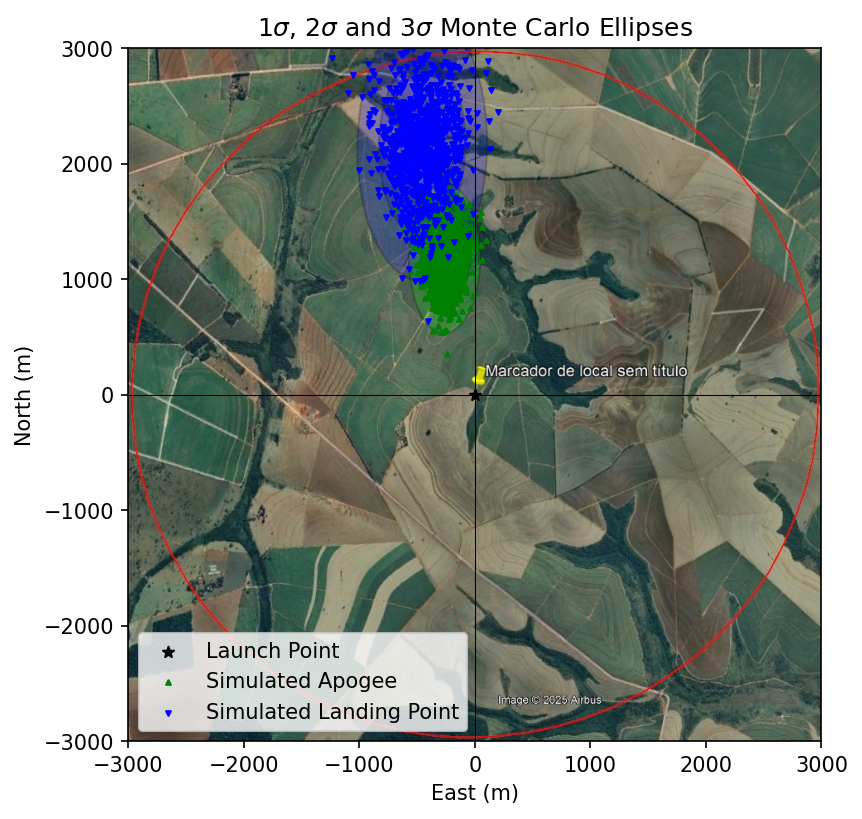

In [ ]:
test_dispersion.plots.ellipses( image="./Aerodinamica/RocketPy.aero/Simulacoes/LASC 2025/IACANGA.jpg", actual_landing_point=None, perimeter_size=3000, xlim=(-3000, 3000), ylim=(-3000, 3000), save=False)

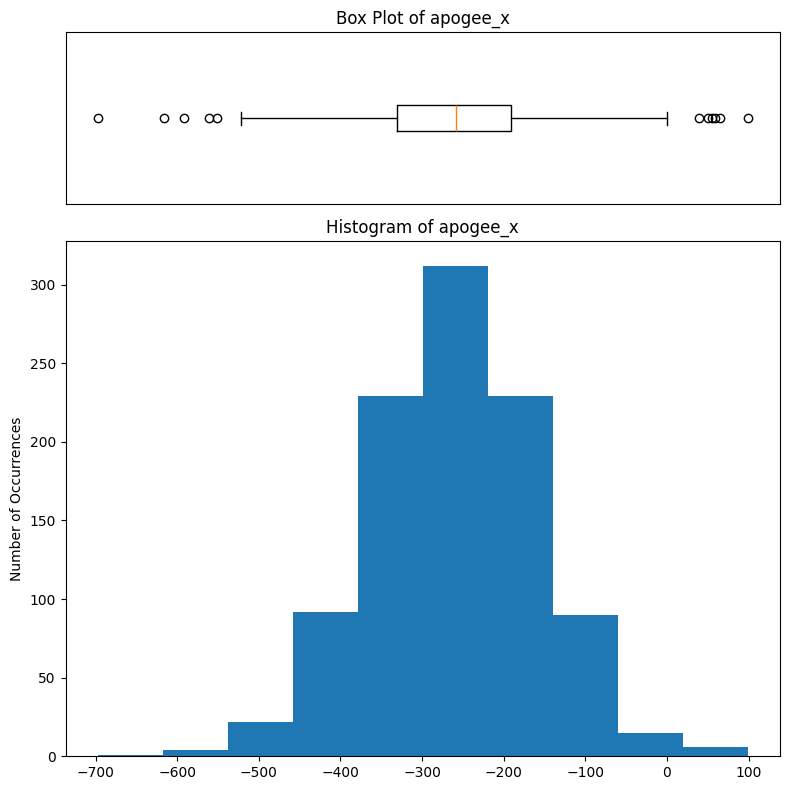

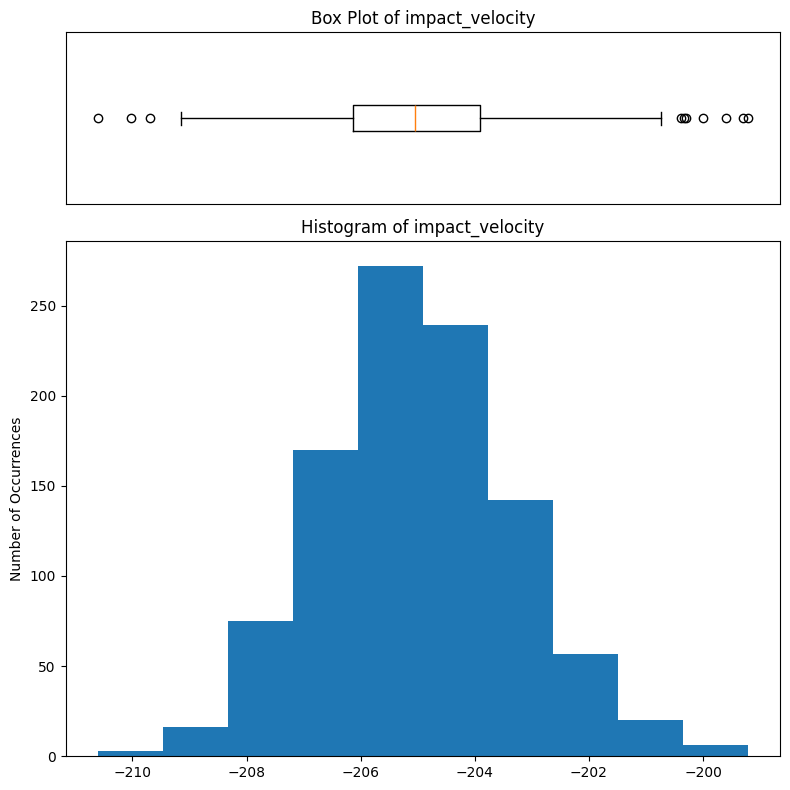

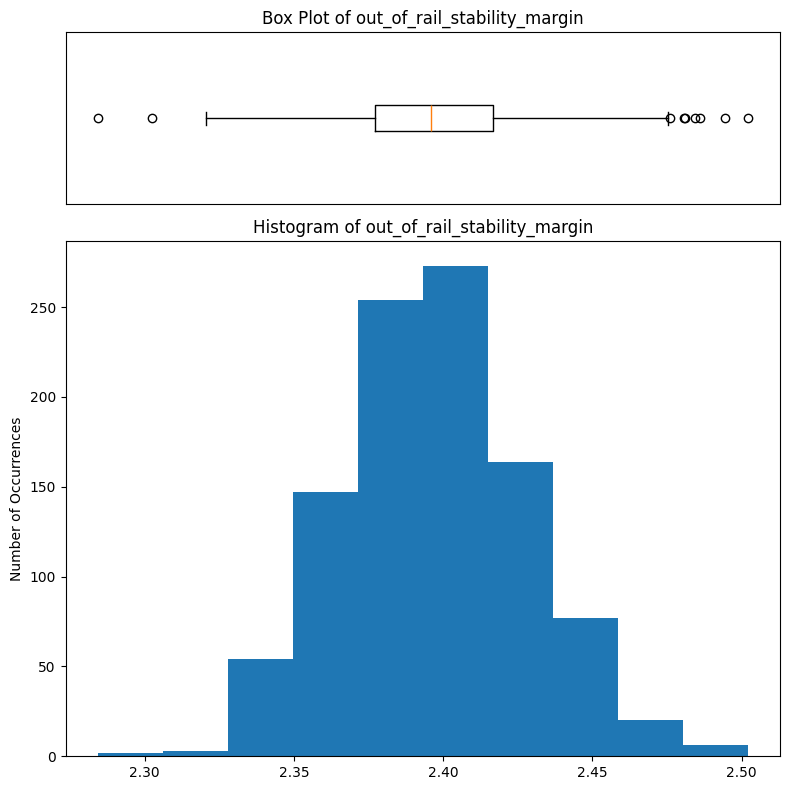

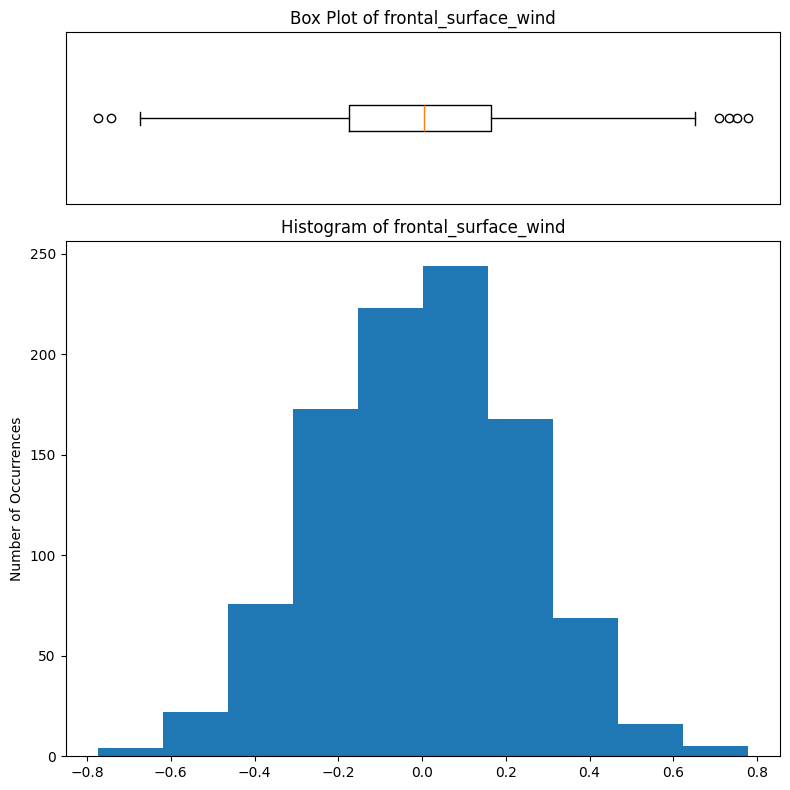

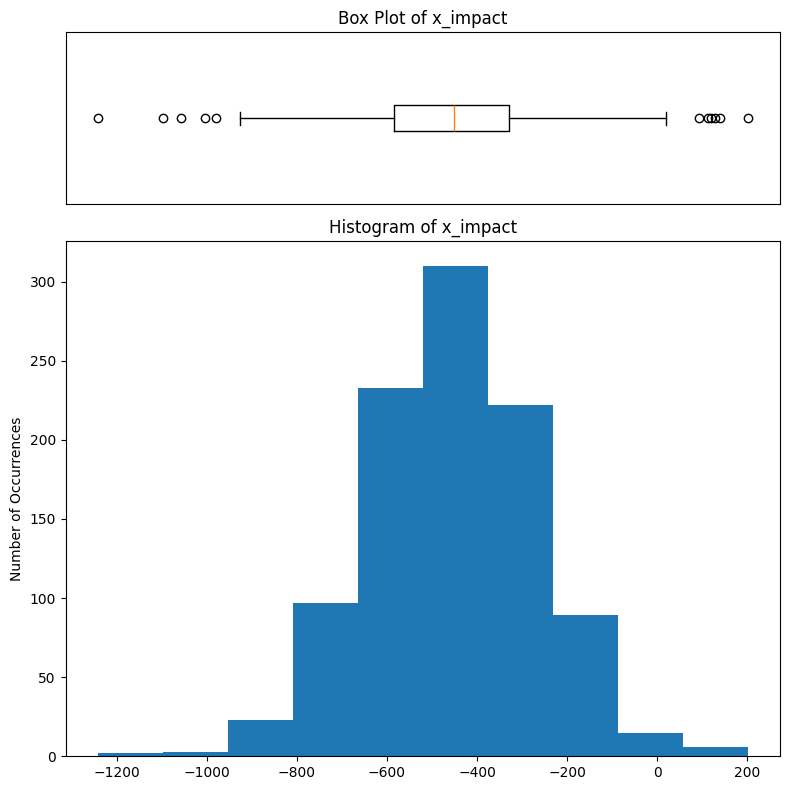

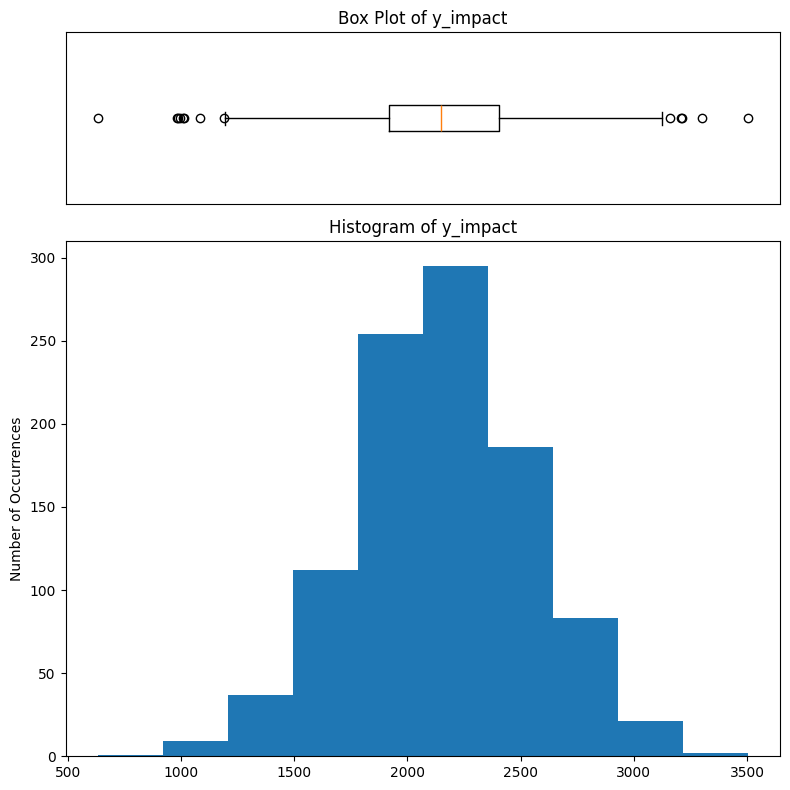

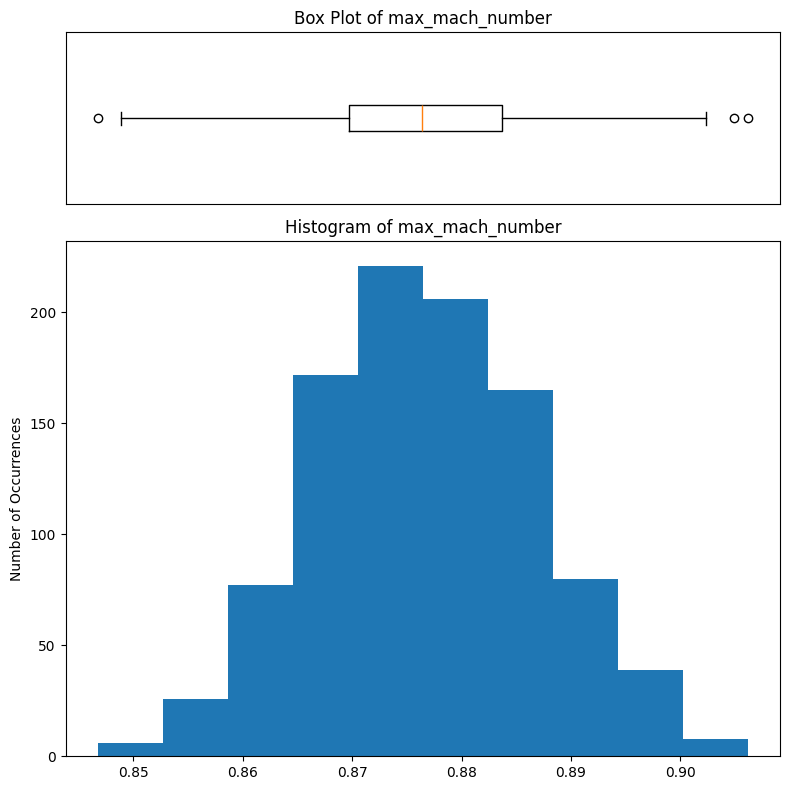

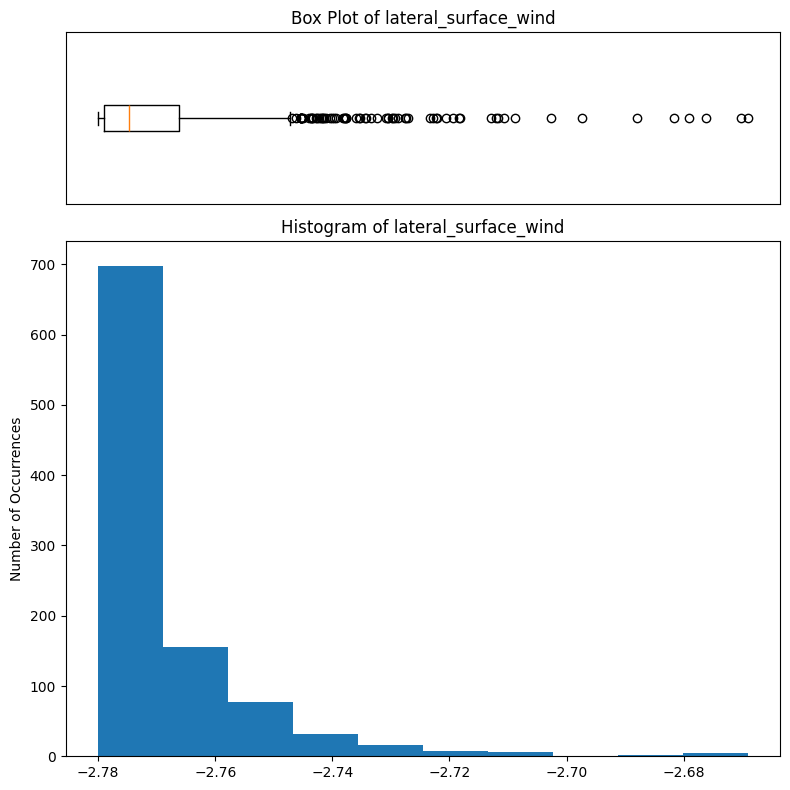

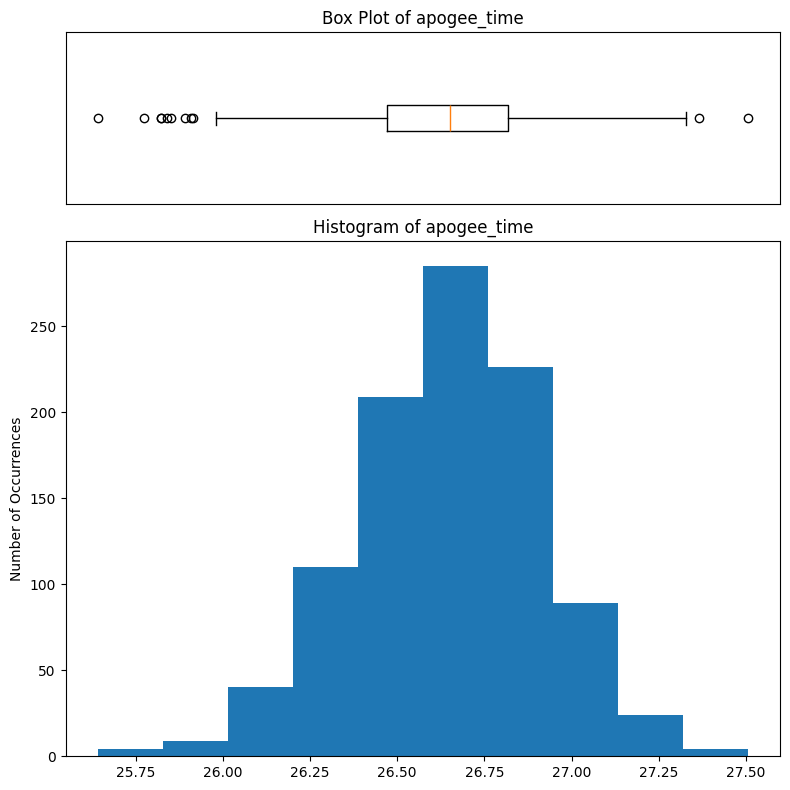

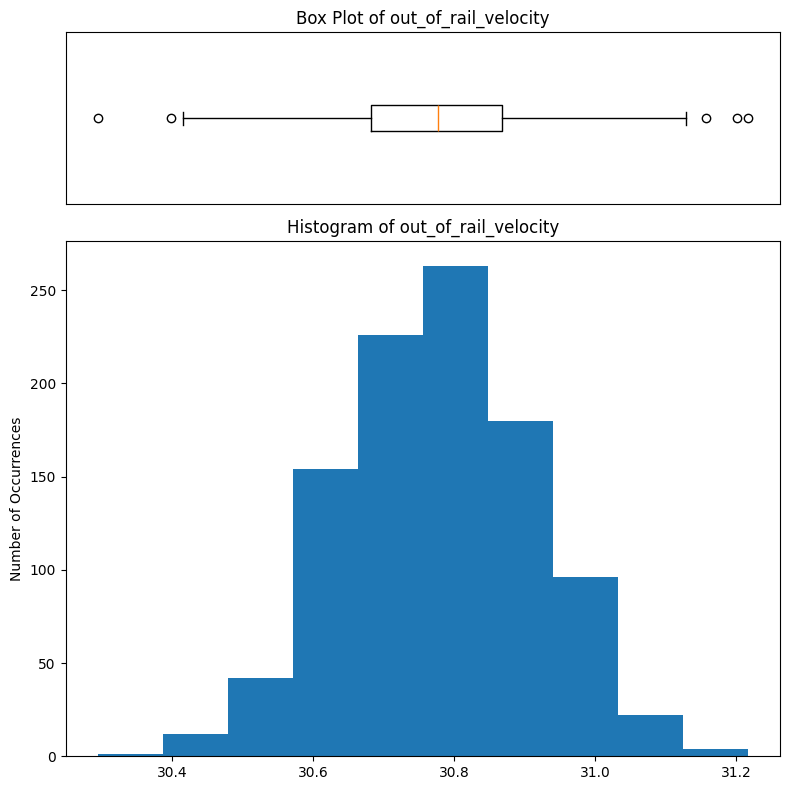

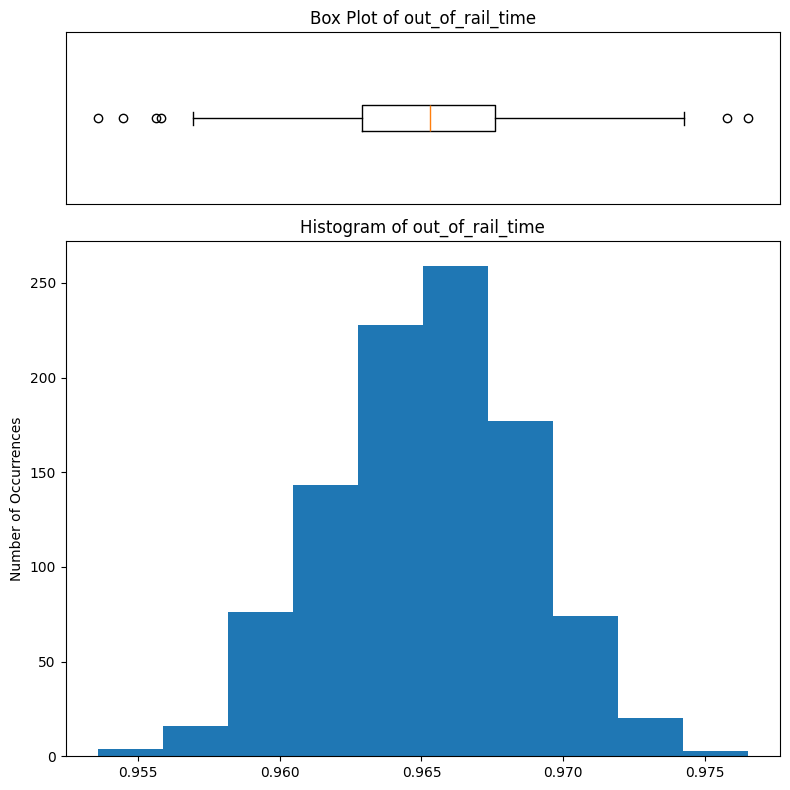

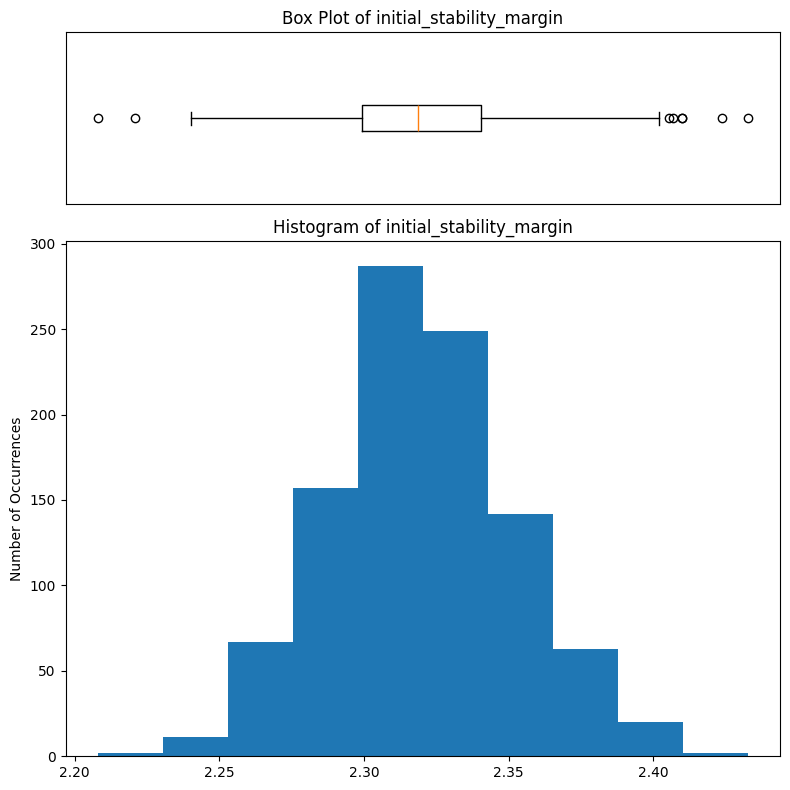

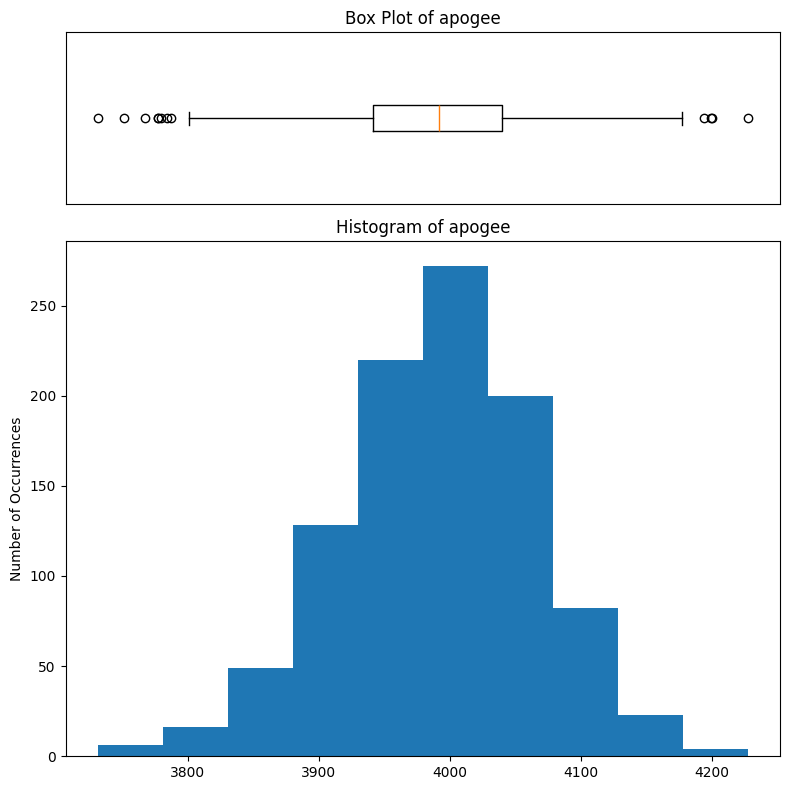

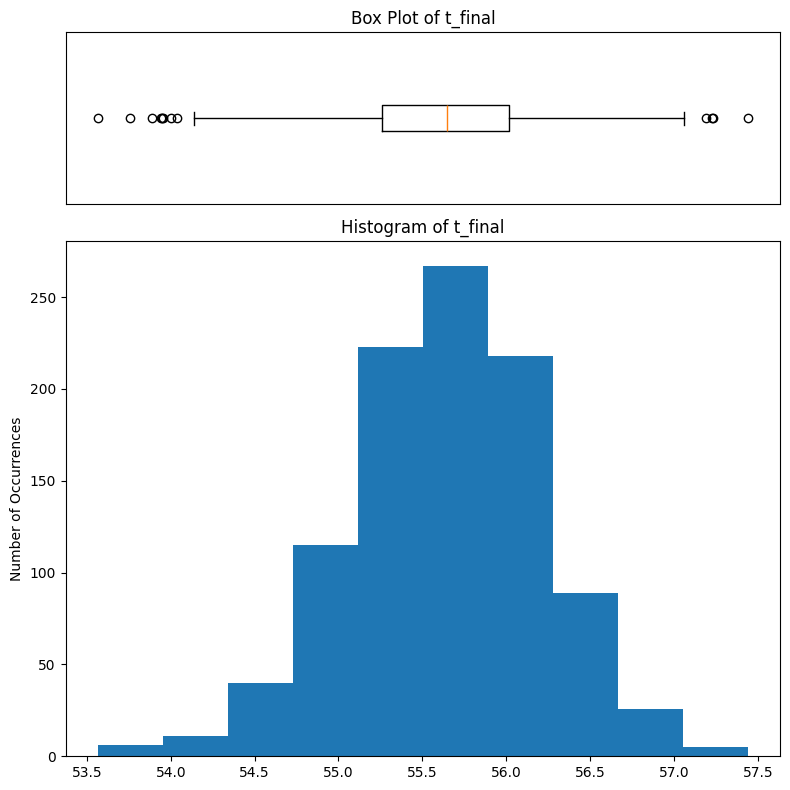

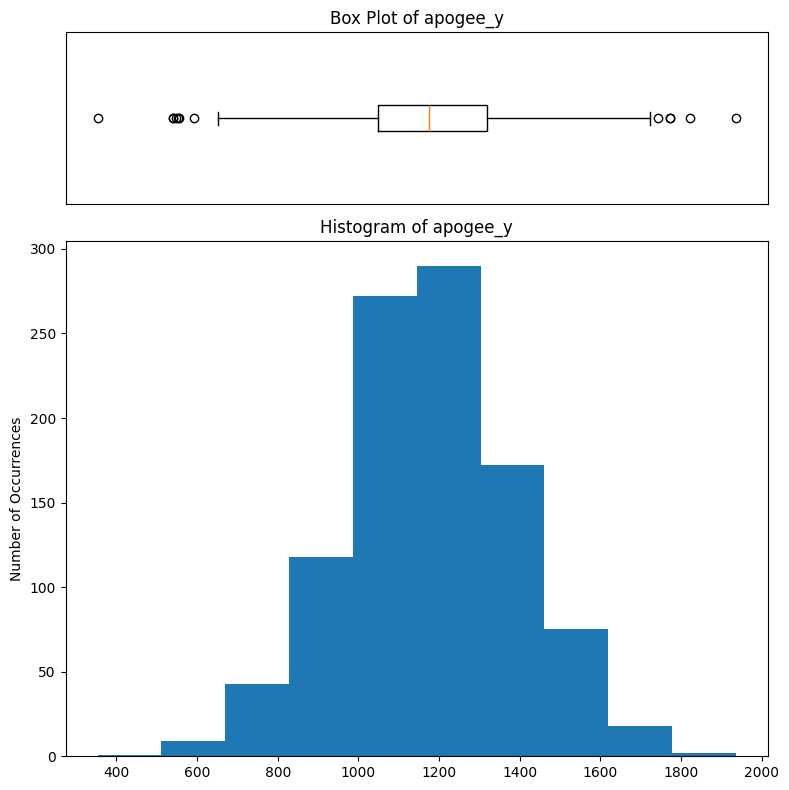

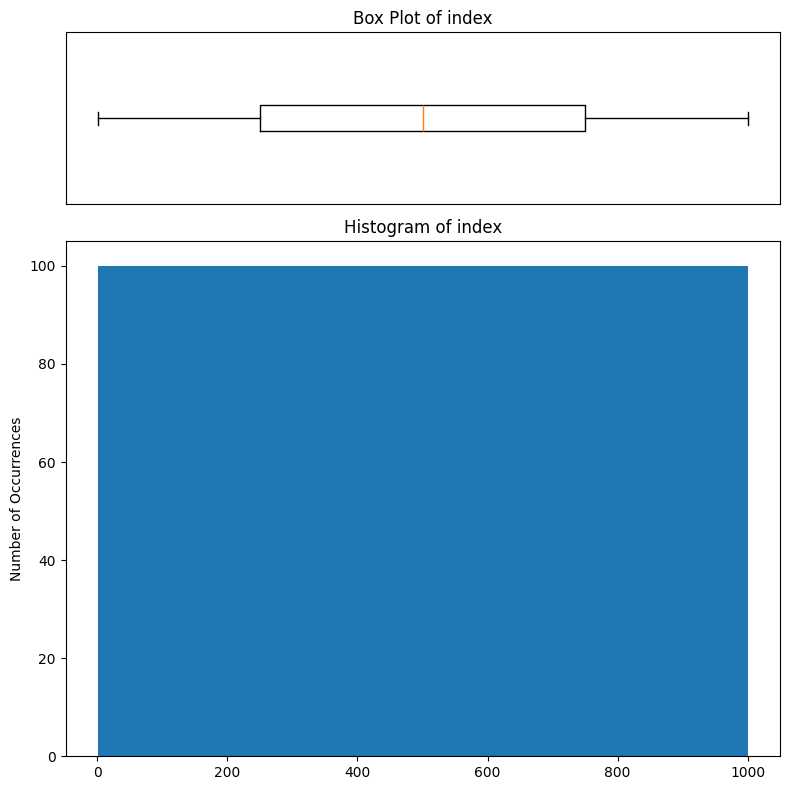

In [ ]:
test_dispersion.plots.all()